In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans

In [2]:
features = pd.read_csv('C:\\Users\\user\\Desktop\\Макс диплом\\features.csv')
features.shape

(236, 323)

In [3]:
features = features.dropna()
features.shape

(235, 323)

In [4]:
features = features.replace('ALIVE (361 days later)', 1768) # max(Survival_days) + 1

In [ ]:
survival_days_clustering = np.array(features['Survival_days']).reshape(-1, 1)
survival_days_clustering

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


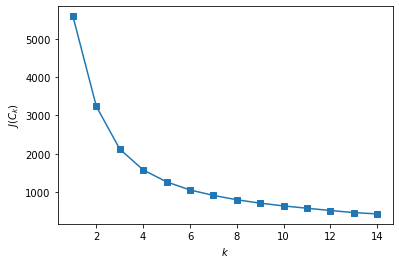

In [6]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=2021).fit(survival_days_clustering)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

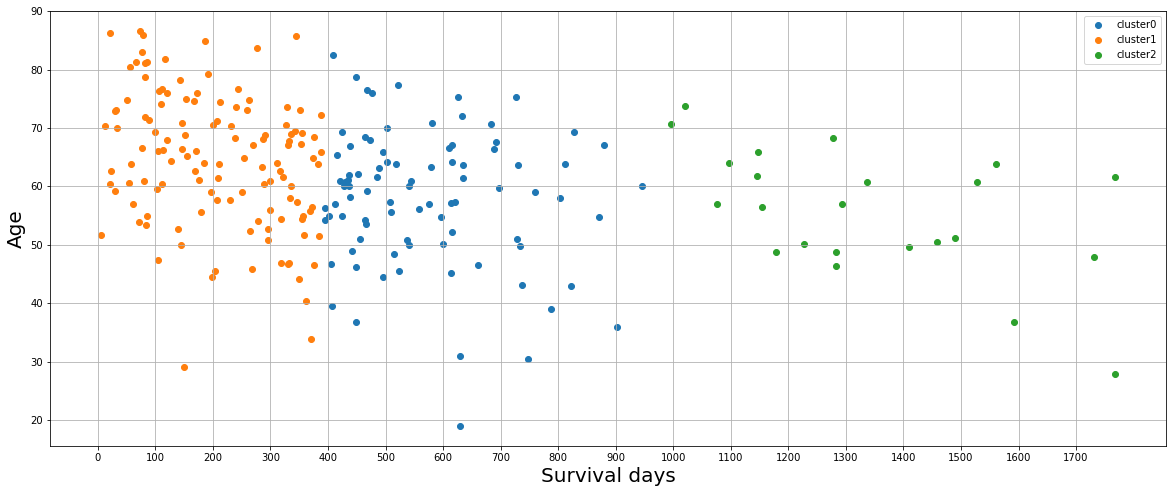

In [7]:
survival_days_kmeans = KMeans(n_clusters=3, random_state=2021).fit(survival_days_clustering)
pred_kmeans = survival_days_kmeans.predict(survival_days_clustering)

survival_days = np.array(features['Survival_days'].apply(lambda x: int(x)))
age = np.array(features['Age'])
plt.figure(figsize=(20,8))

plt.xticks(np.arange(0, max(survival_days), 100));
plt.grid(True)
plt.xlabel('Survival days', size=20);
plt.ylabel('Age', size=20);

for i in range(3):
    plt.scatter(survival_days[pred_kmeans==i], age[pred_kmeans==i], label=f'cluster{i}')
plt.legend()
plt.show()

In [8]:
def to_edge_clusters(survival_days, pred_kmeans, n_clusters):
    cluster_edges = []
    for i in range(n_clusters):
        cluster_edges.append([survival_days[pred_kmeans==i].min(), survival_days[pred_kmeans==i].max()])
    return cluster_edges

In [9]:
edges_clusters = to_edge_clusters(survival_days, pred_kmeans, 3)

for i in range(len(edges_clusters)):
    print(f'min :{edges_clusters[i][0]}, max: {edges_clusters[i][1]}')

min :394, max: 946
min :5, max: 387
min :996, max: 1768


In [10]:
def make_interval(days):
    if 0<=days<=387:
        return 0
    if 388<=days<=946:
        return 1
    if days >= 947:
        return 2

features['Survival_days'] = features['Survival_days'].apply(lambda x: int(x))
features['Survival_interval'] = features['Survival_days']
features['Survival_interval'] = features['Survival_interval'].map(make_interval)

In [11]:
y = features['Survival_interval']
X = features.drop(['Survival_days', 'Survival_interval'], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2021)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
y_train, y_test = np.array(y_train), np.array(y_test)

# Feature Selection and finding hyperparameters

In [ ]:
from tqdm import tqdm

rfc = RandomForestClassifier(random_state=2021)


rfc_params = {'n_estimators': [100]}

cols = []
best_score = 0

for feature in tqdm(list(X.columns)):
    rfc_grid = GridSearchCV(rfc, rfc_params, n_jobs=-1, cv=5, verbose=1, scoring='f1_weighted')
    print('-'*30)
    print('Trying feature: ', feature)
    cols.append(feature)
    rfc_grid.fit(X[cols], y)
    print('CV_score:', rfc_grid.best_score_)
    if rfc_grid.best_score_ < best_score:
        cols.pop()
        print('Feature was not added')
    else:
        best_score = rfc_grid.best_score_
        best_rfc = rfc_grid
        print('Feature was added')
print('Best_score:', best_score)
print('Optimal features:', cols)

In [14]:
cols

['ncr_original_shape_Elongation',
 'ncr_original_shape_Flatness',
 'ncr_original_shape_LeastAxisLength',
 'ncr_original_shape_MajorAxisLength',
 'ncr_original_shape_Maximum2DDiameterRow',
 'ncr_original_shape_Maximum2DDiameterSlice',
 'ncr_original_shape_SurfaceArea',
 'ncr_original_shape_SurfaceVolumeRatio',
 'ncr_original_firstorder_Kurtosis',
 'ncr_original_glcm_Idn',
 'ncr_original_gldm_HighGrayLevelEmphasis',
 'ncr_original_glrlm_RunPercentage']

In [15]:
X_optimal= X[cols]

In [16]:
X_optimal_train = X_train[cols]
X_optimal_test = X_test[cols]

# Random Forest

In [17]:
rfc_params = {'n_estimators': [50,100,150,200,300],
              'criterion': ['entropy', 'gini'],
              'max_depth': [10,20,40,60,'None'],
              'min_samples_split': [2, 3, 4, 5, 6],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_features': ['auto', 'log2']
              }

In [ ]:
rfc = RandomForestClassifier(random_state=2021)

rfc_grid = GridSearchCV(rfc, rfc_params, cv=5, verbose=2, n_jobs=1, scoring='f1_weighted')
rfc_grid.fit(X_optimal, y)

In [19]:
rfc_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [20]:
rfc_grid.best_score_

0.5860918953282034

In [20]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto', 
                             min_samples_leaf=2, min_samples_split=2, n_estimators=100,
                             random_state=2021)
rfc.fit(X_optimal_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       random_state=2021)

In [22]:
from sklearn.metrics import f1_score

rfc_predict = rfc.predict(X_optimal_test)
f1_score(y_test, rfc_predict, average='weighted')

0.5547138047138048

In [111]:
y_test

array([4, 2, 7, 1, 4, 6, 2, 8, 3, 2, 6, 7, 6, 7, 2, 3, 4, 1, 7, 5, 3, 6,
       2, 0, 4, 2, 5, 0, 5, 0, 3, 1, 5, 4, 3, 1], dtype=int64)

In [112]:
rfc_predict

array([4, 3, 4, 3, 7, 6, 2, 3, 7, 3, 2, 7, 3, 6, 2, 5, 8, 4, 6, 4, 3, 1,
       2, 6, 2, 5, 6, 2, 8, 3, 1, 2, 5, 5, 6, 5], dtype=int64)